# Script Contents
#### .01 Import Libraries & Data
#### .02 Explore and Clean Data
#### .03 Create a line chart of the data
#### .04 Decompose the data’s components
#### .05 Conduct a Dickey-Fuller test to check for stationarity
#### .06 Conduct a round of differencing on non-stationary data
#### .07 Check data’s autocorrelations

## .01 Import Libraries & Data

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

In [112]:
# Disable deprecation warnings
warnings.filterwarnings("ignore") 

# Apply a styling option
plt.style.use('fivethirtyeight') 

In [113]:
# Create path to project folder
path = r"C:\Users\jacks\Portuguese Real Estate Analysis\02 Data\Original Data"

In [114]:
# Import data
df = pd.read_csv(os.path.join(path, 'portugal_prices.csv'))

<a href="https://fred.stlouisfed.org/series/QPTR628BIS"> Data source </a>

## .02 Explore and Clean Data

In [117]:
df.head()

,DATE,QPTR628BIS
0,1988-01-01,98.2818
1,1988-04-01,100.4219
2,1988-07-01,102.6592
3,1988-10-01,104.4655
4,1989-01-01,103.8830


In [118]:
# Create a datetime column from "Date"
df['datetime'] = pd.to_datetime(df['DATE']) 

# Set the datetime as the index of the dataframe
df = df.set_index('datetime') 

# Drop the "Date" column
df.drop(['DATE'], axis=1, inplace=True) 

In [119]:
df.head()

,QPTR628BIS
datetime,
1988-01-01,98.2818
1988-04-01,100.4219
1988-07-01,102.6592
1988-10-01,104.4655
1989-01-01,103.8830


In [120]:
# Rename the price index column 
# From the data source, Index 2010=100, Not Seasonally Adjusted
df = df.rename(columns={'QPTR628BIS': 'Index 2010=100'})

In [121]:
df.head()

,Index 2010=100
datetime,
1988-01-01,98.2818
1988-04-01,100.4219
1988-07-01,102.6592
1988-10-01,104.4655
1989-01-01,103.8830


<a href="https://www.bis.org/statistics/pp_selected_documentation.pdf"> Additional info on the calculation of the price index used in this dataset can be found here </a>
#### According to the source, real residential property price are measured with an  inde where the; average for 2010 = 10 and the prices are "calculated by deflating the nominal residential property price series with the Consumer Price Index".  0

In [123]:
# Check the data type
df.dtypes

Index 2010=100    float64
dtype: object

In [124]:
# Check the shape
df.shape

(146, 1)

In [125]:
# Check for missing values
df.isnull().sum() 

Index 2010=100    0
dtype: int64

## .03 Create a line chart of the data

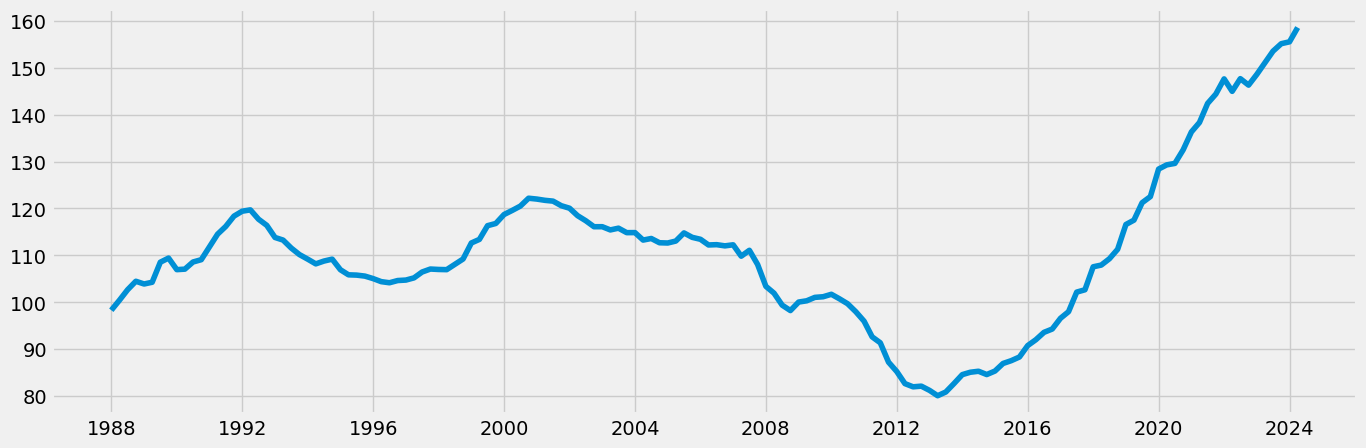

In [127]:
# Using 100 dpi to decrease size of notebook and save RAM
plt.figure(figsize=(15,5), dpi=100) 
plt.plot(df)

#### The plot shows some obvious changes in Portuguese porperty prices over time that likely correlate with economic conditions, such as a large drop in prices following the Great Recession.

## .04 Decompose the data’s components

In [130]:
# First, using an additive model to decompose
decomposition = sm.tsa.seasonal_decompose(df, model='additive')

In [131]:
# Defining a fixed size for all special charts.
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

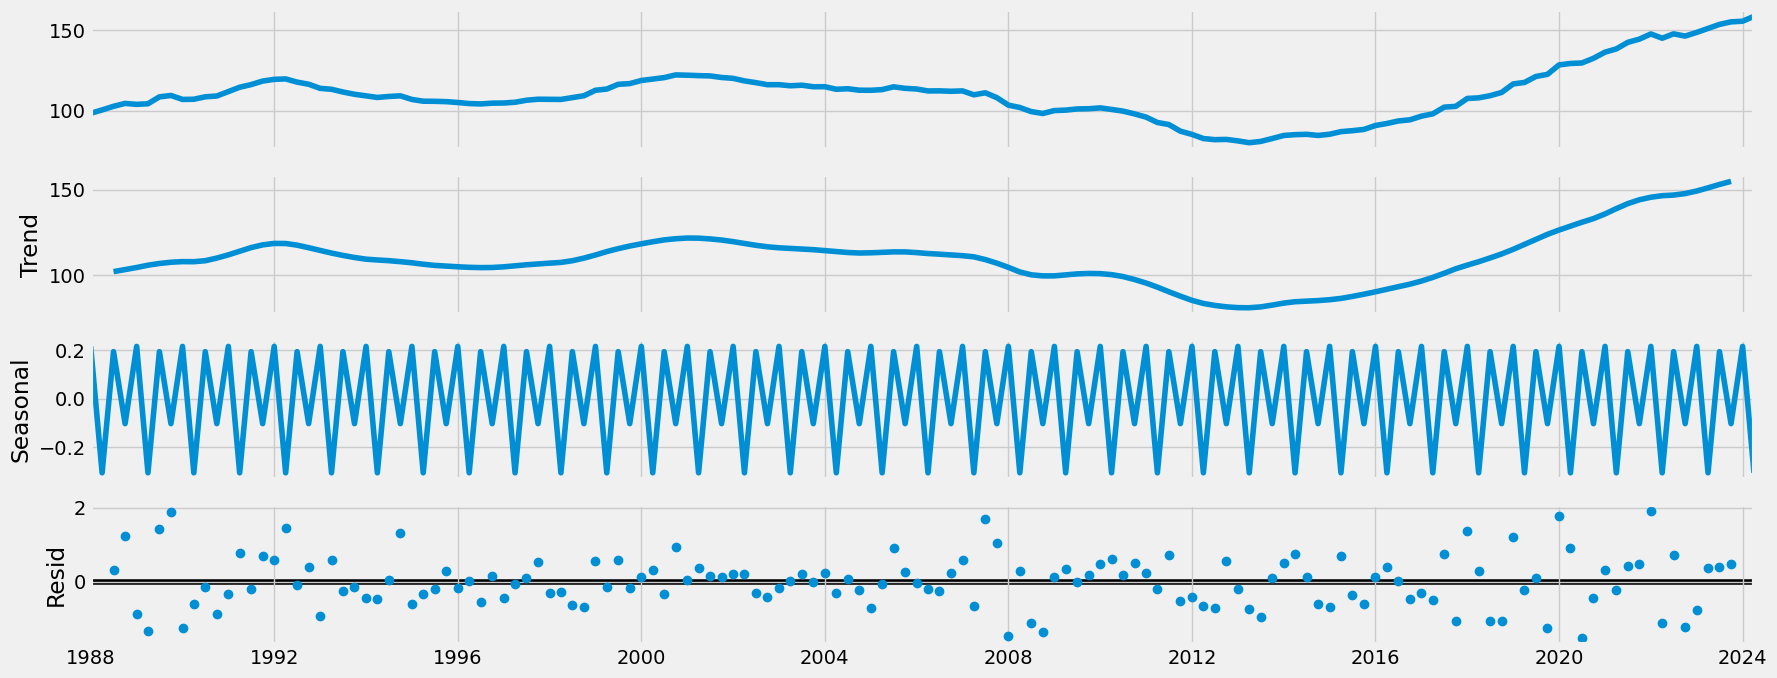

In [132]:
# Plot the separated components
decomposition.plot()
plt.show()

In [133]:
# Second, using an multiplicative  model to decompose
decomposition = sm.tsa.seasonal_decompose(df, model='multiplicative ')

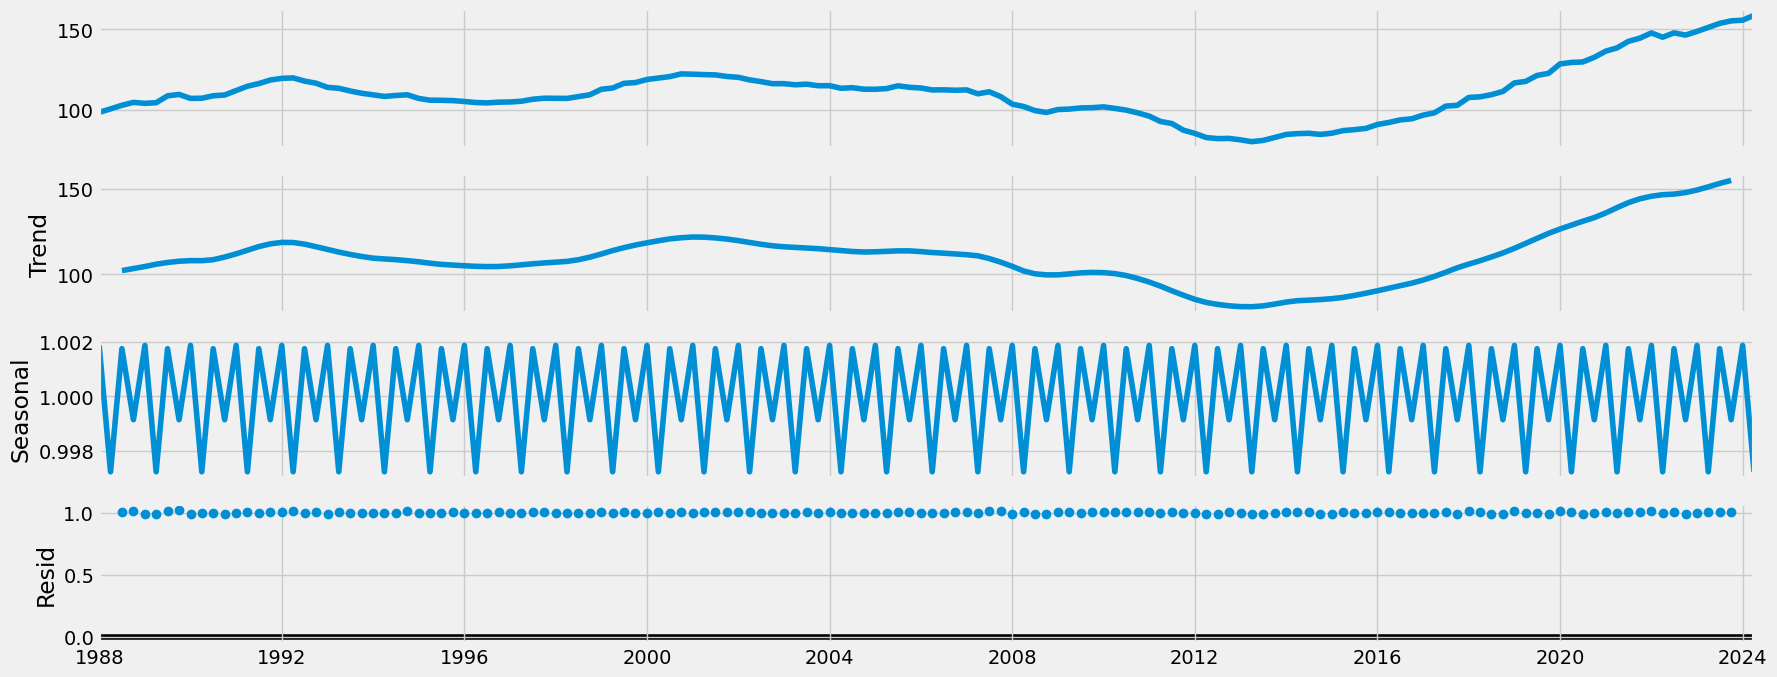

In [134]:
# Plot the separated components
decomposition.plot()
plt.show()

#### Based on the plots, the additive decomposition model appears to be a better fit. There is little difference in the additive and multiplicative models aside from the residual plot. The additive residual plot appears to capture noise in the data while the multiplicative residual plot appears to overfit the data. However, the data does appear to need smoothing based on the level of noise captured by the additive residual plot and the slight differences seen between the level and the trend plot.

In [250]:
# Attemtping to smooth the data with a Savitzky-Golay filter in order to preserve peaks and troughs 
from scipy.signal import savgol_filter
df['Price Index Smoothed'] = savgol_filter(df['Index 2010=100'], window_length=10, polyorder=3)

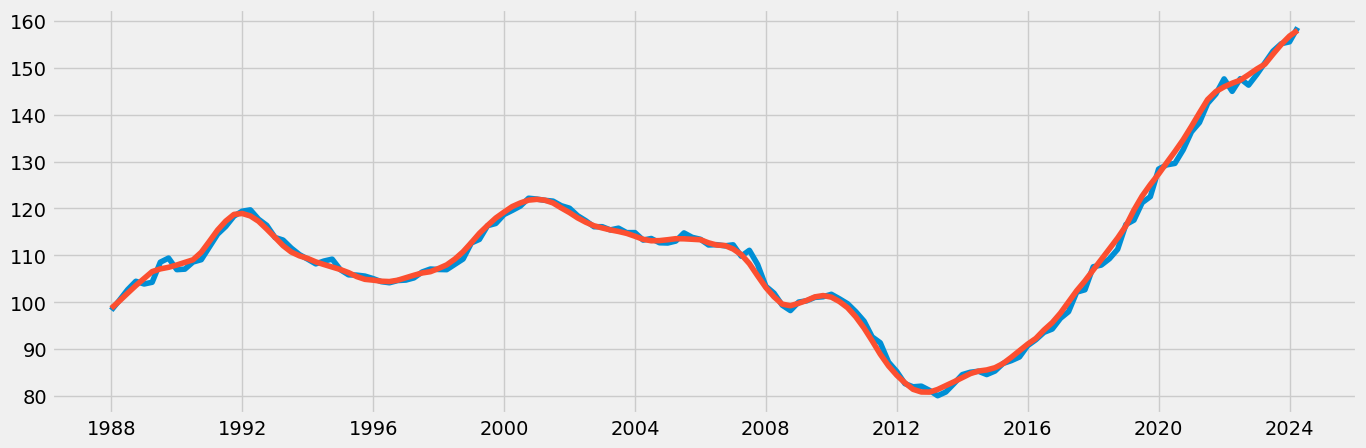

In [251]:
plt.figure(figsize=(15,5), dpi=100) 
plt.plot(df)

#### The filter does appear to have smoothed the data while maintaining the important features

In [253]:
df.head()

,Index 2010=100,Price Index Smoothed
datetime,,
1988-01-01,98.2818,98.692728
1988-04-01,100.4219,100.259495
1988-07-01,102.6592,101.913507
1988-10-01,104.4655,103.550030
1989-01-01,103.8830,105.064327


In [254]:
# Drop the original price index column
df_smoothed = df.drop('Index 2010=100', axis=1)

In [255]:
df_smoothed.head()

,Price Index Smoothed
datetime,
1988-01-01,98.692728
1988-04-01,100.259495
1988-07-01,101.913507
1988-10-01,103.550030
1989-01-01,105.064327


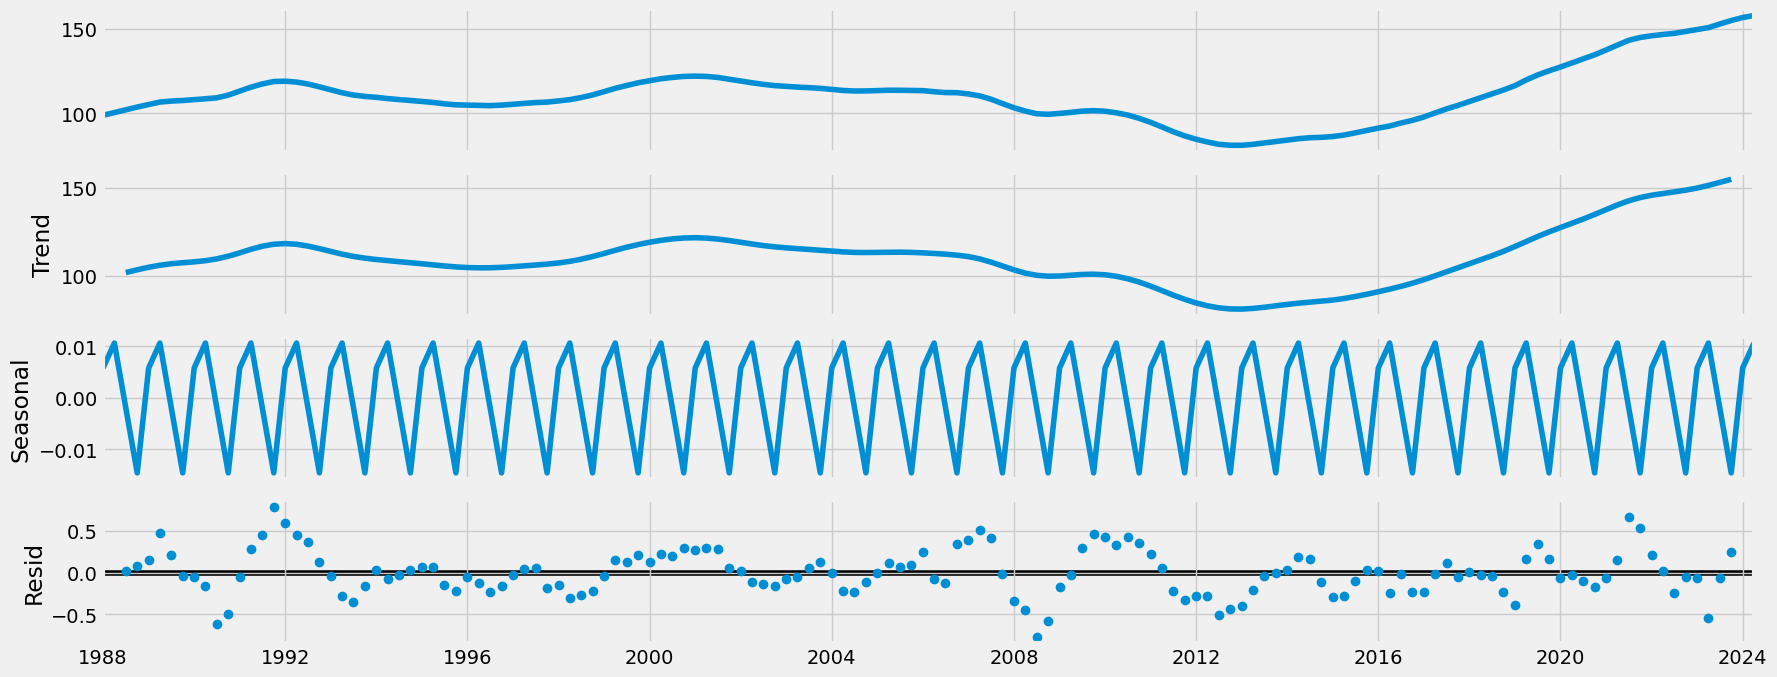

In [256]:
# Using additive model to decompose smoothe data
decomposition = sm.tsa.seasonal_decompose(df_smoothed, model='additive')
decomposition.plot()
plt.show()

#### The smoothing does appear to have decrased the noise captured by the residual plot and has made the level and trend plots appear nearly identical. The trend plot appears to capture the fluctuations seen in the property pricing overtime, with some slight ups and downs from 1988 to ~2007, a dip from 2008 to 2013 and an upward trend from 2013 until present. The seasonality plot shows the presence of seasonality in this data. The residual plot shows the presence of noise in the data after removing trends and seasonality. There is some unexplained noise present in the data which seems to correspond with the level and trend plots of the data, such as the increase around 1992 and decrease around 2008. I believe this means that there may be excessive noise in the data that, even after smoothing, cannot be separated by removing the trend and seasonality. 

## .05 Conduct a Dickey-Fuller test to check for stationarity

In [273]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller 
# Define the function
def dickey_fuller(timeseries): 
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_smoothed['Price Index Smoothed'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.365160
p-value                          0.151812
Number of Lags Used             11.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64


#### The null hypothesis is the presence of a unit root. 

#### The alternative hypothesis is that there’s no unit root. 

#### The presence of a root unit is determined by comparing the test statistic to the critical values. If the test statistic is larger than the critical values, then we cannot reject the null hypothesis. 

#### The test statistic is larger than all critical values so we cannot reject the null hypothesis, meaning there is a unit root present and the data is not stationary. 

## .06 Conduct a round of differencing on non-stationary data

In [277]:
# Apply differencing to the df
data_diff = df_smoothed - df_smoothed.shift(1)

# Remove any mising values as a result of the differencing
data_diff.dropna(inplace=True)

In [279]:
data_diff.head()

,Price Index Smoothed
datetime,
1988-04-01,1.566767
1988-07-01,1.654012
1988-10-01,1.636522
1989-01-01,1.514297
1989-04-01,1.462908


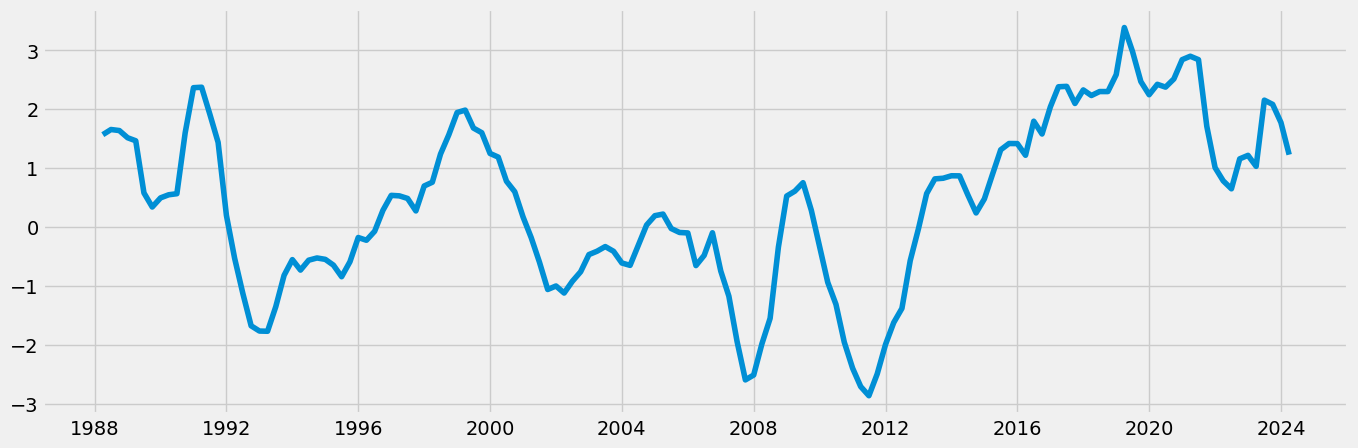

In [283]:
# PLot differenced data
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [285]:
# Check differenced data for stationarity using the Dickey-Fuller test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -1.822993
p-value                          0.369107
Number of Lags Used             10.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64


#### The results of the test do not reject the null hypothesis that there is presence of a unit root because the test statistic is larger than the critical values. 

In [288]:
# Perfrom another round of differencing to the df
data_diff_2 = data_diff - data_diff.shift(1)

# Remove any mising values as a result of the differencing
data_diff_2.dropna(inplace=True)

In [290]:
data_diff_2.head()

,Price Index Smoothed
datetime,
1988-07-01,0.087245
1988-10-01,-0.017490
1989-01-01,-0.122225
1989-04-01,-0.051389
1989-07-01,-0.884746


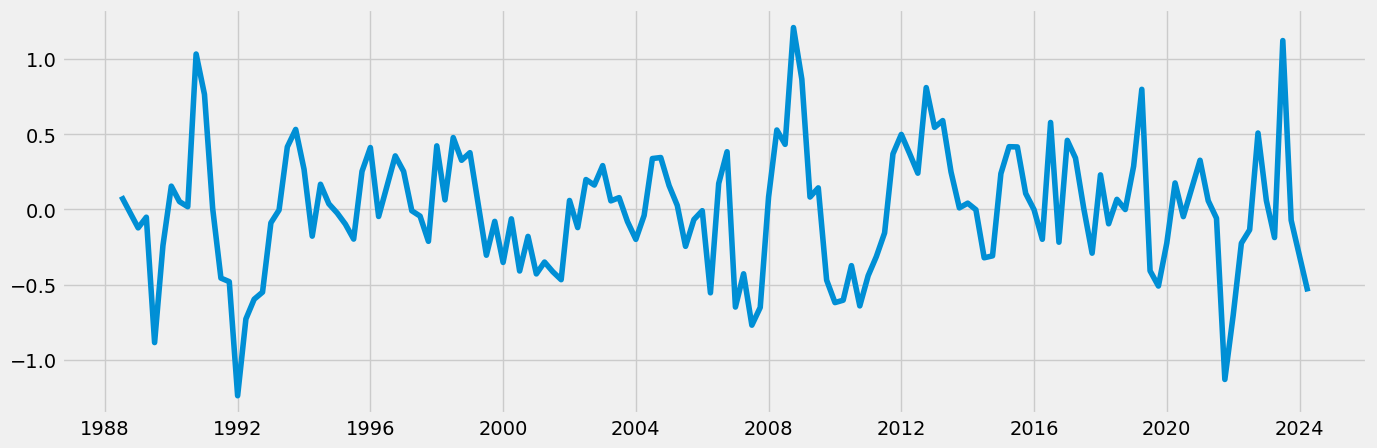

In [294]:
# PLot differenced data
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [292]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                  -5.002286
p-value                          0.000022
Number of Lags Used              9.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64


#### After 2 rounds of differencing, we can reject the null hypothesis that there is a unit root present because the test statistic is smaller than all critical values. Also, the p-value is now at a significant level (less than .05). 

## .07 Check data’s autocorrelations

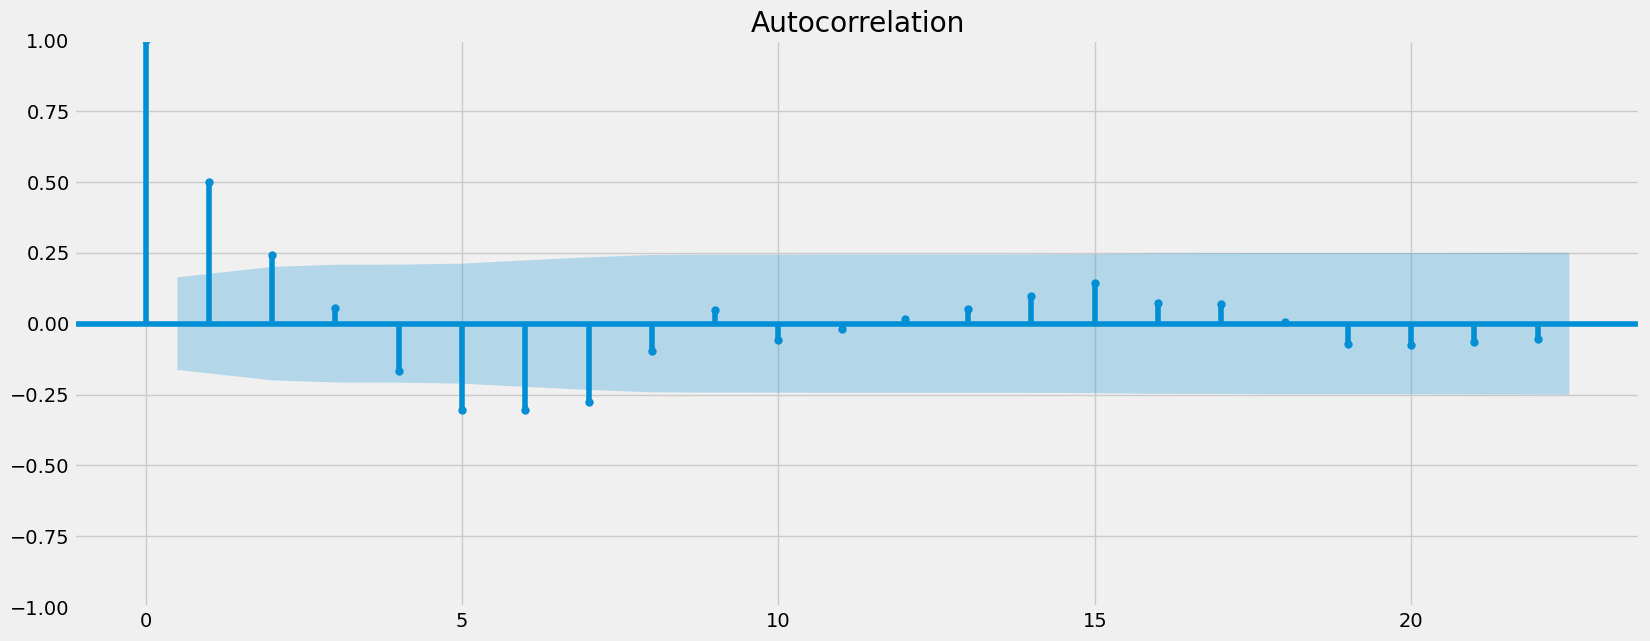

In [298]:
# Import the autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

# Check out a plot of autocorrelations
plot_acf(data_diff_2)
plt.show()

#### There are few lags outside of the confidence interval, indicating stationary data.

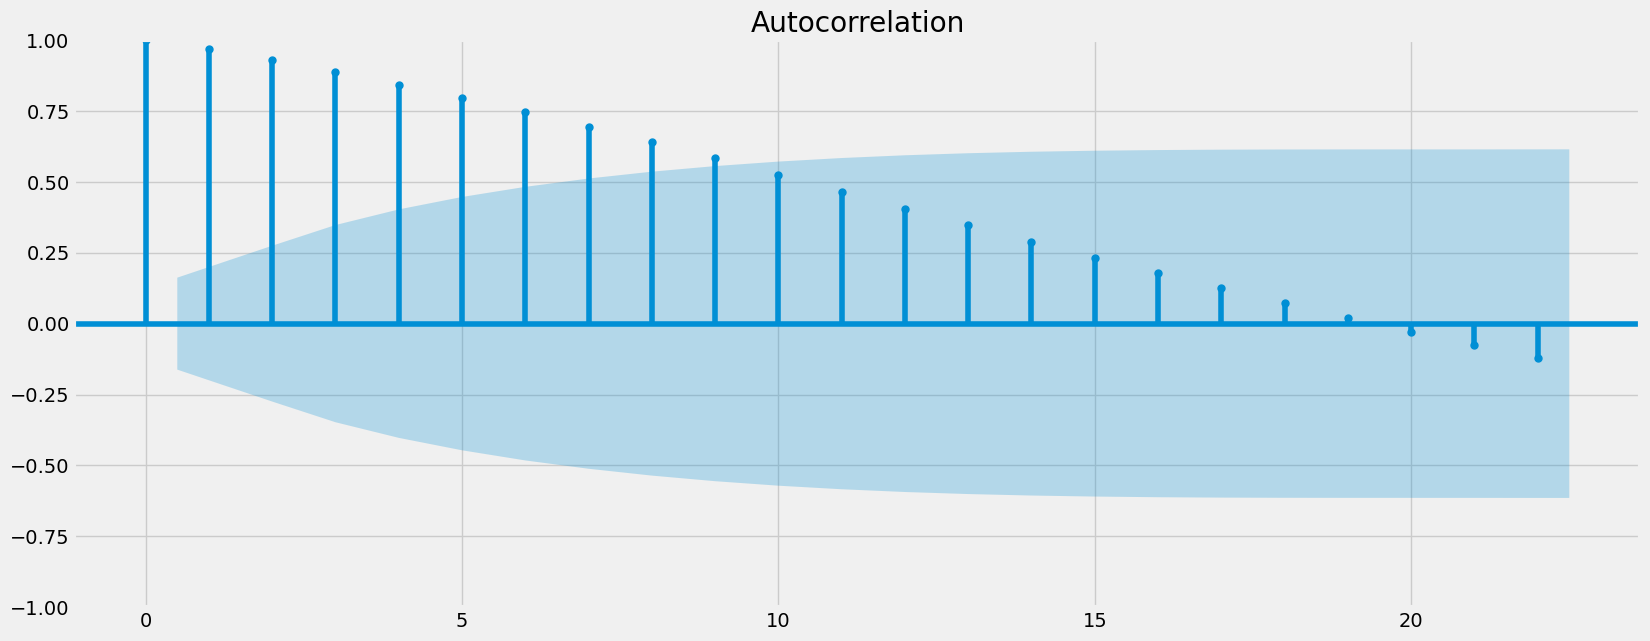

In [301]:
# Plotting non-differenced data for comparison
plot_acf(df_smoothed)
plt.show()

#### As expected, there are several lags outside of the confidence interval. 